##########**TRABAJO FINAL- VISÓN 3D**#################

Importamos las librerías necesarias:

In [3]:
import numpy as np
import cv2
import glob #la librería glob sirve para encontrar los nombres de los archivos 
import matplotlib.pyplot as plt

Cargar las imagenes del tablero para la calibracion de la cámara y su previa detección con opencv de las esquinas y la lectura de las imagenes

In [5]:

# Cargar las imágenes corregidas del tablero de ajedrez que hemos hecho previamente
images = glob.glob('./undistorted_*.jpeg')

# Definimos los parámetros del tablero para la detección
square_size = 25  # Tamaño de cada cuadro
pattern_size = (7, 7)  # Número de cuadros del patrón de ajedrez
contador = 0

# Crear las coordenadas 3D reales de los puntos del tablero
object_points = np.zeros((np.prod(pattern_size), 3), np.float32) 

# Suponemos que el patrón es plano sobre z=0, y que cada cuadro tiene tamaño "square_size"
# Se genera una lista con las posiciones (x, y, 0) de cada esquina, organizadas en filas y columnas
object_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2) * square_size # 

# Listas para almacenar los puntos 3D y 2D
obj_points = []  # 3D objeto real el tablero
img_points = []   # 2D la imagen 

# Leer la primera imagen para obtener el tamaño
img = cv2.imread(images[0])
h, w = img.shape[:2]

# Definir parámetros de la cámara
camera_matrix = np.array([[w, 0, w / 2],
                          [0, w, h / 2],
                          [0, 0, 1]], dtype=np.float32)

dist_coeffs = np.zeros(4)  # distorsion 0 


for image_path in images:
    img = cv2.imread(image_path)
    
    # Convierte la imagen a escal de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Detectar las esquinas
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    if ret: #si detecta las esquinas las añade en la lista
        obj_points.append(object_points)  # añade los ptos 3d
        img_points.append(corners)  # Agregar ptos 2d
        cv2.drawChessboardCorners(img, pattern_size, corners, ret)# dibuja esquinas
        cv2.imshow('Imagen de ajedrez', img) #muestra imagen
        cv2.waitKey(500)  
    else: #por is no detecta las esquinas
        print("No se han encontrado esquinas",1 )

for i, (obj, img) in enumerate(zip(obj_points, img_points)):
    print(f"Imagen {i+1}: {len(obj)} puntos 3D - {len(img)} puntos 2D")

print(f"\nTotal de imágenes válidas: {len(obj_points)}")
print(f"Total de correspondencias: {len(obj_points) * len(object_points)}")
cv2.destroyAllWindows()


No se han encontrado esquinas 1
Imagen 1: 49 puntos 3D - 49 puntos 2D
Imagen 2: 49 puntos 3D - 49 puntos 2D
Imagen 3: 49 puntos 3D - 49 puntos 2D
Imagen 4: 49 puntos 3D - 49 puntos 2D
Imagen 5: 49 puntos 3D - 49 puntos 2D
Imagen 6: 49 puntos 3D - 49 puntos 2D
Imagen 7: 49 puntos 3D - 49 puntos 2D
Imagen 8: 49 puntos 3D - 49 puntos 2D
Imagen 9: 49 puntos 3D - 49 puntos 2D
Imagen 10: 49 puntos 3D - 49 puntos 2D
Imagen 11: 49 puntos 3D - 49 puntos 2D
Imagen 12: 49 puntos 3D - 49 puntos 2D
Imagen 13: 49 puntos 3D - 49 puntos 2D
Imagen 14: 49 puntos 3D - 49 puntos 2D
Imagen 15: 49 puntos 3D - 49 puntos 2D
Imagen 16: 49 puntos 3D - 49 puntos 2D
Imagen 17: 49 puntos 3D - 49 puntos 2D
Imagen 18: 49 puntos 3D - 49 puntos 2D
Imagen 19: 49 puntos 3D - 49 puntos 2D
Imagen 20: 49 puntos 3D - 49 puntos 2D

Total de imágenes válidas: 20
Total de correspondencias: 980


Algoritmo de calibracion que saca la matriz de proyeccion P

In [7]:
def zhang_calibration(object_points_list, image_points_list):
    A = []
    B = []
    
    for i in range(len(image_points_list)):
        image_points = image_points_list[i]
        object_points = object_points_list[i]
        
        for j in range(len(image_points)):
            X, Y, Z = object_points[j]
            x, y = image_points[j].ravel()
            
            A.append([X, Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x])
            A.append([0, 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y])
            B.append([x])
            B.append([y])

    A = np.array(A)
    B = np.array(B) 

    P = np.linalg.lstsq(A, B, rcond=None)[0]  
 
    P = P.reshape(3, 4)
    P = P / P[2, 3]
    return P


In [8]:
def decompose_projection_matrix_lstsq(P):
  
    M = P[:, :3]  
    t = P[:, 3]  #ultima columna
    
    # Descomposición QR de la inversa de M
    Q, U = np.linalg.qr(np.linalg.inv(M))
    
 
    D = np.diag(np.sign(np.diag(U)) * [-1, -1, 1])  # Ajustamos los signos de U
    Q = np.dot(Q, D)  # Aplicamos la matriz D a Q
    U = np.dot(D, U)  # Aplicamos la matriz D a U
    
    #  K (distancia focal)
    K = np.linalg.inv(U / U[2, 2])  # La matriz K se obtiene con la inversión de U normalizada
    
    #  rotación R
    s = np.linalg.det(Q)  # Determinante de Q, para verificar el signo de la rotación
    R = s * Q.T  # La rotación se obtiene de Q transpuesta ajustada por el determinante
    
    #  vector de traslación t
    t = s * np.dot(U, P[:, 3])  # El vector de traslación se calcula a partir de U y P
    
    return K, R, t

In [9]:
def normalize_points(points):
    
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])

    # Obtener la media y desviación estándar
    mean = np.mean(points_homogeneous, axis=0)
    std_dev = np.std(points_homogeneous)

    # Matriz de normalización
    T = np.array([[1/std_dev, 0, -mean[0]/std_dev],
                  [0, 1/std_dev, -mean[1]/std_dev],
                  [0, 0, 1]])

    # Normalizar los puntos
    points_normalized = np.dot(T, points_homogeneous.T).T

    return points_normalized, T

In [10]:
def eight_point_algorithm(x1, x2):#calcula la matriz f a partir de 8 pares de puntos corresponidentes 
    
    A = []
    for i in range(8):
        x1i, y1i = x1[i][0], x1[i][1]
        x2i, y2i = x2[i][0], x2[i][1]
        A.append([x2i * x1i, x2i * y1i, x2i, y2i * x1i, y2i * y1i, y2i, x1i, y1i, 1])
    
    A = np.array(A)  
    #svd
    _, _, Vt = np.linalg.svd(A)
    
    # coge el ultimo vector 
    F = Vt[-1].reshape(3, 3)
    
    # para que sea rango 2
    U, S, Vt = np.linalg.svd(F)
    S[2] = 0 #valor singular 0 ultimo
    F = np.dot(U, np.dot(np.diag(S), Vt))
    
    return F

In [11]:
def ransac_fundamental_matrix(x1, x2, threshold=0.5, max_iters=2000): #
    best_F = None
    best_inliers = None
    max_inliers_count = 0
    
    for i in range(max_iters):
        # 8 puntos random, f provisional
        indices = np.random.choice(len(x1), 8, replace=False)
        x1_subset = x1[indices]
        x2_subset = x2[indices]      
    
        x1_normalized, T1 = normalize_points(x1_subset)
        x2_normalized, T2 = normalize_points(x2_subset)
        F_normalized = eight_point_algorithm(x1_normalized, x2_normalized)#calculo de F con los 8 puntos normalizados 
        
        # Desnormalizar f
        F = T2.T @ F_normalized @ T1
        
        errors = []
        for i in range(len(x1)):
            x1i = np.append(x1[i], 1)  # Convertir a coordenadas homogéneas
            x2i = np.append(x2[i], 1) 
            l2 = F @ x1i
            l1 = F.T @ x2i
            
            dist1 = np.abs(x2i.T @ F @ x1i) / np.sqrt(l2[0]**2 + l2[1]**2)
            dist2 = np.abs(x2i.T @ F @ x1i) / np.sqrt(l1[0]**2 + l1[1]**2)
            
            error_geom = dist1 + dist2
            errors.append(error_geom)
        
        errors = np.array(errors)
        inliers = errors < threshold
        inliers_count = np.sum(inliers)
        
        if inliers_count > max_inliers_count:
            best_F = F
            best_inliers = inliers
            max_inliers_count = inliers_count
    
    return best_F, best_inliers 

In [12]:
def detectar_coincidencias_SIFT(img1,img2):
    
    # Detectar características SIFT
    sift = cv2.SIFT_create()
    puntos_clave1, descriptores1 = sift.detectAndCompute(img1, None)
    puntos_clave2, descriptores2 = sift.detectAndCompute(img2, None)#puntos clave  lista de objetos con posicion, orientacion
    
    # Emparejar características
    bf = cv2.BFMatcher(cv2.NORM_L2)#matcher con distancia euclidea
    coincidencias = bf.knnMatch(descriptores1, descriptores2, k=2)
    
    # Filtrar coincidencias con la prueba, david lower, matches buenos
    buenas_coincidencias = []
    for m, n in coincidencias:
        if m.distance < 0.5 * n.distance:
            buenas_coincidencias.append(m)
    print(f"Buenas coicidencias {len(buenas_coincidencias)}")
    if len(buenas_coincidencias) < 4:
        print("No hay suficientes coincidencias buenas.")
        exit()
    
    # Extraer puntos correspondientes
    puntos1 = np.float32([puntos_clave1[m.queryIdx].pt for m in buenas_coincidencias]) #cordenadas 2d de los puntos claves 
    puntos2 = np.float32([puntos_clave2[m.trainIdx].pt for m in buenas_coincidencias])
    return puntos1, puntos2, coincidencias

In [13]:
def calcular_matriz_esencial(F, K):
   
    #Cálculamos la matriz esencial a traves de la ecuación E=K' F K 
    E = np.dot(np.dot(K.T, F), K)
    
    print("Matriz Esencial E:")
    print(E)
    
    return E


In [14]:

P = zhang_calibration(obj_points, img_points)

print("Matriz de proyección P:")
print(P)

Matriz de proyección P:
[[-4.80048712e-15  3.63331849e-15 -3.90312782e-17 -1.95030452e-13]
 [ 1.93648153e-15 -3.56088378e-16  1.73472348e-18 -2.34187269e-13]
 [-4.91207518e-16  5.82050255e-16 -0.00000000e+00  1.00000000e+00]]


In [15]:
K, R, t = decompose_projection_matrix_lstsq(P)

print("Matriz intrínseca K:")
print(K)

print("Matriz de rotación R:")
print(R)

print("Vector de traslación t:")
print(t)

Matriz intrínseca K:
[[-0.04883308  1.74023192  7.71084515]
 [-0.         -1.64156324 -1.99713994]
 [ 0.          0.          1.        ]]
Matriz de rotación R:
[[ 1.06036337e-03  8.94868539e-04 -9.99999037e-01]
 [ 7.64224338e-01  6.44949018e-01  1.38750142e-03]
 [ 6.44949639e-01 -7.64225074e-01  5.53619502e-17]]
Vector de traslación t:
[-1.50398354e+17  1.59739263e+15 -1.31298813e+15]


In [16]:

# Cargar las imágenes izquierda y derecha
image_left = cv2.imread('izquierda.jpeg', cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread('derecha.jpeg', cv2.IMREAD_GRAYSCALE)

x1, x2, matches = detectar_coincidencias_SIFT(image_left,image_right)
# Aplicar RANSAC para obtener la matriz fundamental
F, inliers = ransac_fundamental_matrix(x1, x2)

# Mostrar la matriz fundamental F
print("Matriz Fundamental F:")
print(F)

Buenas coicidencias 133
Matriz Fundamental F:
[[-8.99619102e-07  3.21796340e-06 -2.75502671e-03]
 [-3.21036201e-06 -9.06514361e-07  3.68296516e-03]
 [ 4.02224630e-03 -1.81550452e-03 -1.39526262e+00]]


In [17]:
K = np.array([
    [1.49186453e+03, 2.42000798e-13, 7.75788473e+02],
    [0.00000000e+00, 1.49615689e+03, 1.01688705e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])
E = calcular_matriz_esencial(F, K)

Matriz Esencial E:
[[-2.00224605  7.18269831 -0.26948375]
 [-7.16573152 -2.0292192   0.40483104]
 [ 0.08914878 -0.3603768   0.01400161]]


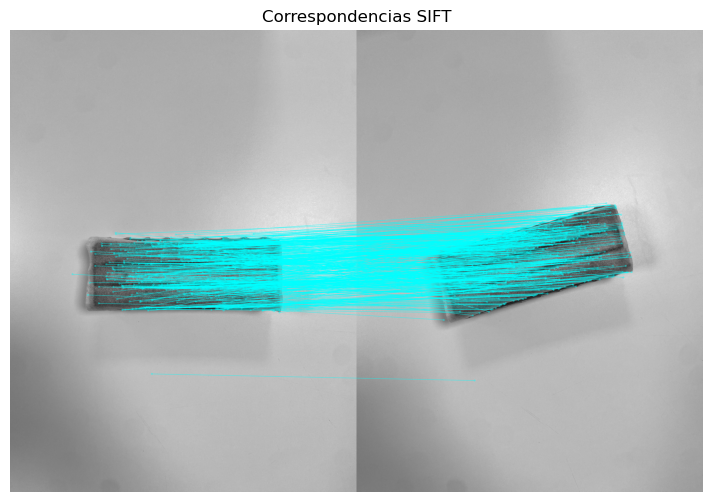

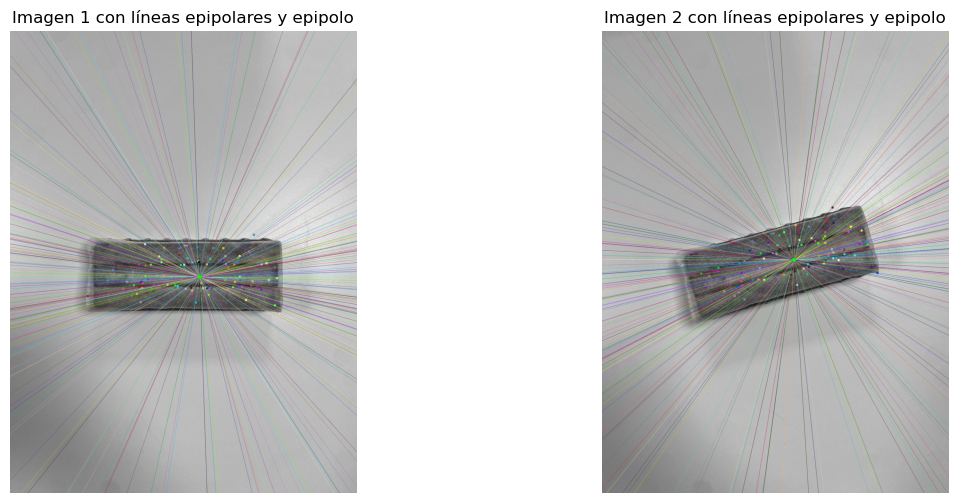

In [18]:

def process_and_show_matches_with_epilines(img1_path, img2_path, F, pts1, pts2):

    # Cargar imágenes en escala de grises
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                  matchColor=(0, 255, 255), singlePointColor=(0, 0, 255), flags=2)

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches)
    plt.title("Correspondencias SIFT")
    plt.axis('off')
    plt.show()

    # Calcular líneas epipolares para puntos dados
    lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
    lines2 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)

    def draw_lines(img, lines, pts):
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        h, w = img.shape
        for r, pt in zip(lines, pts):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = 0, int(-r[2] / r[1])
            x1, y1 = w, int(-(r[2] + r[0] * w) / r[1])
            cv2.line(img_color, (x0, y0), (x1, y1), color, 1)
            cv2.circle(img_color, tuple(pt.astype(int)), 5, color, -1)
        return img_color

    img1_lines = draw_lines(img1, lines2, pts1)
    img2_lines = draw_lines(img2, lines1, pts2)

    # Dibujar epipolos
    epipole1 = np.linalg.svd(F)[2][-1]
    epipole2 = np.linalg.svd(F.T)[2][-1]
    epipole1 = (epipole1 / epipole1[2])[:2].astype(int)
    epipole2 = (epipole2 / epipole2[2])[:2].astype(int)

    cv2.circle(img1_lines, tuple(epipole1), 8, (0, 255, 0), -1)
    cv2.circle(img2_lines, tuple(epipole2), 8, (0, 255, 0), -1)

    # Mostrar imágenes con líneas epipolares y epipolos
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen 1 con líneas epipolares y epipolo")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen 2 con líneas epipolares y epipolo")
    plt.axis('off')
    plt.show()
process_and_show_matches_with_epilines('izquierda.jpeg', 'derecha.jpeg', F, x1, x2)

In [19]:
K = np.array([
    [1.49186453e+03, 2.42000798e-13, 7.75788473e+02],
    [0.00000000e+00, 1.49615689e+03, 1.01688705e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])
def normalizar_par_puntos(p1, p2, K):
  
    K_inv = np.linalg.inv(K)

    p1_h = np.array([p1[0], p1[1], 1.0])
    p2_h = np.array([p2[0], p2[1], 1.0])

    y1 = K_inv @ p1_h
    y2 = K_inv @ p2_h

    y1 /= y1[2]
    y2 /= y2[2]

    return y1, y2

img1 = cv2.imread('izquierda.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('derecha.jpeg', cv2.IMREAD_GRAYSCALE)

puntos1, puntos2, _ = detectar_coincidencias_SIFT(img1, img2)
i = 0  # índice del punto que quieres normalizar

y1, y2 = normalizar_par_puntos(puntos1[i], puntos2[i], K)

print("Punto normalizado en imagen 1:", y1)
print("Punto normalizado en imagen 2:", y2) 

Buenas coicidencias 133
Punto normalizado en imagen 1: [-0.28936089  0.10501175  1.        ]
Punto normalizado en imagen 2: [-0.25451753  0.14148589  1.        ]


In [20]:
def compute_relative_pose(E, y1, y2):
    # 1. Compute SVD of E=U S V^T 
    U, S, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    # 2. Definir matriz W
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    # 3. Calcular las 4 poses principales
    posibles_poses = [
        (U @ W @ Vt,  U[:, 2]),
        (U @ W @ Vt, -U[:, 2]),
        (U @ W.T @ Vt,  U[:, 2]),
        (U @ W.T @ Vt, -U[:, 2])
    ]

    # Matriz identidad 3x4 para cámara 1 (referencia)
    I = np.eye(3)
    zero = np.zeros((3,1))

    # 4. Para cada una de las 4 poses
    for R, t in posibles_poses:
        # Matrices de proyección cámara 1 y cámara 2
        P1 = np.hstack((I, zero))
        P2 = np.hstack((R, t.reshape(3,1)))

        # 4. Triangular punto 3D x correspondiente a y1,y2
        A = np.zeros((4,4))
        A[0] = y1[0]*P1[2] - P1[0]
        A[1] = y1[1]*P1[2] - P1[1]
        A[2] = y2[0]*P2[2] - P2[0]
        A[3] = y2[1]*P2[2] - P2[1]

        _, _, Vt_a = np.linalg.svd(A)
        X = Vt_a[-1]
        X /= X[3]

        # 5. Coordenadas relativas a cámara 1
        x_cam1 = X[:3]

        # 6. Coordenadas en cámara 2
        x_cam2 = R @ x_cam1 + t

        # 7. Devolver pose si x3 > 0 en ambas cámaras
        if x_cam1[2] > 0 and x_cam2[2] > 0:
            return R, t

    
    raise RuntimeError("No se encontró pose válida donde el punto esté delante de ambas cámaras.")

R, t = compute_relative_pose(E, y1, y2)

print("Matriz de rotación R:\n", R)
print("Vector de traslación t:\n", t)

Matriz de rotación R:
 [[ 0.96248236  0.27130677 -0.00451055]
 [-0.271282    0.96177249 -0.03741319]
 [-0.00581233  0.03723317  0.9992897 ]]
Vector de traslación t:
 [-0.04969809  0.00146102 -0.99876322]


In [21]:
def calcular_homografias_rectificacion(K, R, t):
    
    t = t / np.linalg.norm(t)

    # Elegir vector arbitrario diferente de t para construir la base
    z_axis = np.array([0, 0, 1])
    if np.abs(np.dot(t, z_axis)) > 0.999:  # si t casi paralelo a z
        z_axis = np.array([0, 1, 0])       # cambiar vector de referencia

    r1 = t
    r2 = np.cross(z_axis, r1)
    r2 /= np.linalg.norm(r2)
    r3 = np.cross(r1, r2)

    R_rect = np.vstack((r1, r2, r3)).T

    Hl = K @ R_rect @ np.linalg.inv(K)
    Hr = K @ R_rect @ R.T @ np.linalg.inv(K)

    return Hl, Hr

In [94]:
Hl, Hr = calcular_homografias_rectificacion(K, R, t)

print("Homografía izquierda Hl:\n", Hl)
print("Homografía derecha Hr:\n", Hr)

def descomponer_homografia(H):
    H = H / H[2, 2]  # Normalizar

    # Traslación
    T = np.array([
        [1, 0, H[0, 2]],
        [0, 1, H[1, 2]],
        [0, 0, 1]
    ])

    # Submatriz para rotación y escala
    M = H[0:2, 0:2]

    # Descomposición polar para separar R y S
    U, Sigma, Vt = np.linalg.svd(M)
    R = U @ Vt
    S = Vt.T @ np.diag(Sigma) @ Vt

    # Perspectiva
    P = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [H[2, 0], H[2, 1], 1]
    ])
    print("Matriz de traslación T:\n", T)
    print("\nMatriz de rotación R (2D):\n", R)
    print("\nMatriz de escala y deformación S (2D):\n", S)
    print("\nMatriz de perspectiva P:\n", P)

    return T, R, S, P

T, R, S, P = descomponer_homografia(Hl)


Homografía para cámara izquierda (H_l):
 [[-2.96185783e-01 -3.42956576e-01  2.11767160e+03]
 [-1.20377900e+00  1.38607835e-01  8.59042164e+02]
 [-4.36472740e-04 -5.05396291e-04  9.17556355e-01]]

Homografía para cámara derecha (H_r):
 [[-1.97764498e-01 -3.71669879e-01  2.09061285e+03]
 [-1.19658363e+00 -1.90701944e-01  1.18862564e+03]
 [-2.82851218e-04 -6.02536576e-04  9.28340213e-01]]
Homografía izquierda Hl:
 [[-2.96185783e-01 -3.42956576e-01  2.11767160e+03]
 [-1.20377900e+00  1.38607835e-01  8.59042164e+02]
 [-4.36472740e-04 -5.05396291e-04  9.17556355e-01]]
Homografía derecha Hr:
 [[-1.97764498e-01 -3.71669879e-01  2.09061285e+03]
 [-1.19658363e+00 -1.90701944e-01  1.18862564e+03]
 [-2.82851218e-04 -6.02536576e-04  9.28340213e-01]]
Matriz de traslación T:
 [[1.00000000e+00 0.00000000e+00 2.30794718e+03]
 [0.00000000e+00 1.00000000e+00 9.36228232e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Matriz de rotación R (2D):
 [[-0.27061536 -0.96268755]
 [-0.96268755  0.27061536]]

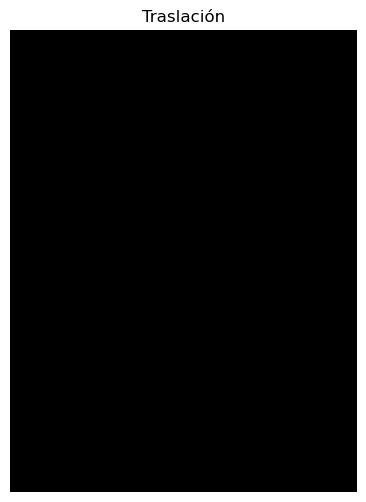

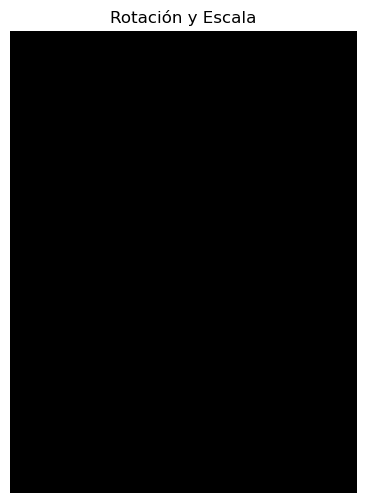

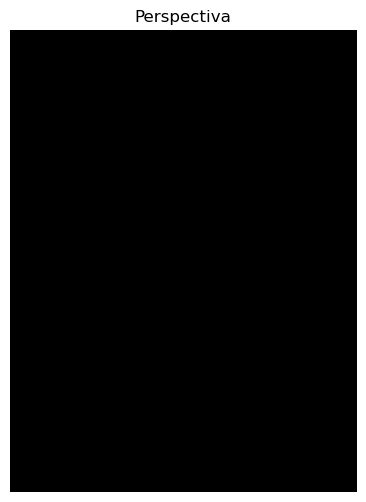

In [23]:

def show_rectified_images_with_epilines(img1_path, img2_path, Hl, Hr, pts1, pts2):
   
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Validar carga
    if img1 is None or img2 is None:
        raise ValueError("Error al cargar las imágenes.")

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Normalizar homografías
    Hl = Hl / Hl[2, 2]
    Hr = Hr / Hr[2, 2]

    # Rectificar imágenes
    img1_rect = cv2.warpPerspective(img1, Hl, (w1, h1))
    img2_rect = cv2.warpPerspective(img2, Hr, (w2, h2))

    # Función para dibujar líneas horizontales y puntos
    def draw_horizontal_lines(img, pts):
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for pt in pts:
            y = int(round(pt[1]))
            color = tuple(np.random.randint(0, 255, 3).tolist())
            cv2.line(img_color, (0, y), (img.shape[1], y), color, 1)
            cv2.circle(img_color, (int(round(pt[0])), y), 5, color, -1)
        return img_color

    # Transformar puntos con homografías
    def transform_points(pts, H):
        pts_h = np.hstack([pts, np.ones((pts.shape[0],1))]).T
        pts_rect_h = H @ pts_h
        pts_rect = (pts_rect_h[:2] / pts_rect_h[2]).T
        return pts_rect

    pts1_rect = transform_points(pts1, Hl)
    pts2_rect = transform_points(pts2, Hr)

    img1_lines = draw_horizontal_lines(img1_rect, pts1_rect)
    img2_lines = draw_horizontal_lines(img2_rect, pts2_rect)

    # Mostrar imágenes rectificadas
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen izquierda rectificada con líneas epipolares")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen derecha rectificada con líneas epipolares")
    plt.axis('off')

    plt.show()

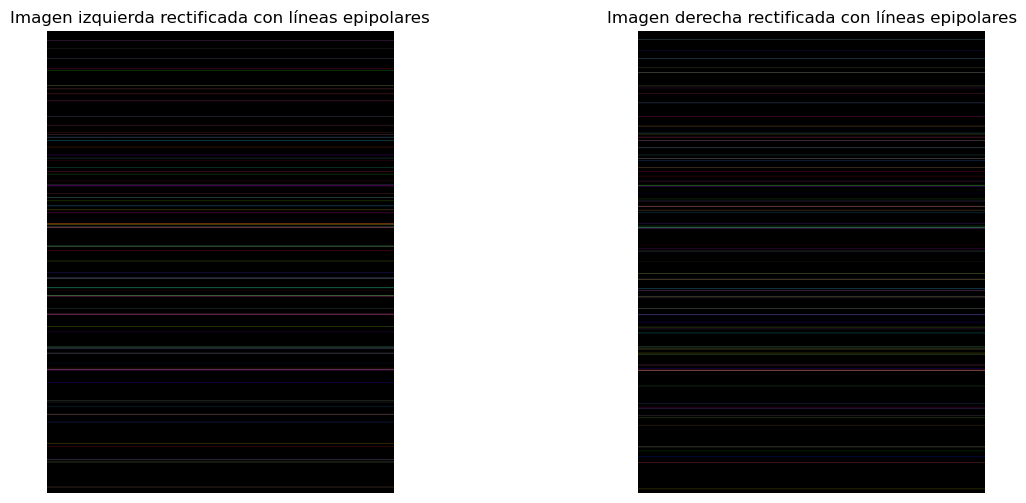

In [24]:
show_rectified_images_with_epilines('izquierda.jpeg', 'derecha.jpeg', Hl, Hr, puntos1, puntos2)

Configuración válida: Caso 2


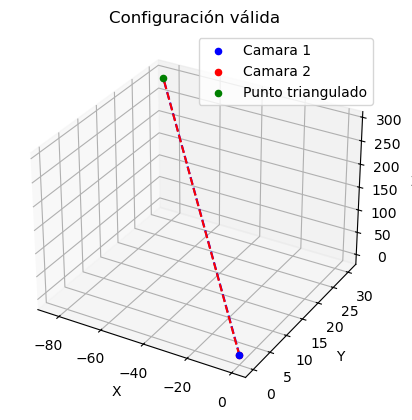

In [49]:
def compute_svd(E):
    U, _, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1
    return U, Vt

def compute_possible_poses(U, Vt):
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    t = U[:, 2]
    return [(R1, t), (R1, -t), (R2, t), (R2, -t)]

def triangulate_point(P1, P2, y1, y2):
    A = np.array([
        y1[0] * P1[2] - P1[0],
        y1[1] * P1[2] - P1[1],
        y2[0] * P2[2] - P2[0],
        y2[1] * P2[2] - P2[1]
    ])
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]
    return X[:3] / X[3]

def visualize_configuration(x, t, R):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cam1 = np.zeros(3)
    cam2 = t

    ax.scatter(*cam1, color='blue', label='Camara 1')
    ax.scatter(*cam2, color='red', label='Camara 2')
    ax.scatter(*x, color='green', label='Punto triangulado')

    ax.plot([cam1[0], x[0]], [cam1[1], x[1]], [cam1[2], x[2]], 'b--')
    ax.plot([cam2[0], x[0]], [cam2[1], x[1]], [cam2[2], x[2]], 'r--')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title('Configuración válida')
    plt.show()

def encontrar_pose_valida(E, y1, y2):
    U, Vt = compute_svd(E)
    poses = compute_possible_poses(U, Vt)

    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # Camara 1 en el origen

    for i, (R, t) in enumerate(poses):
        P2 = np.hstack((R, t.reshape(3, 1)))
        X = triangulate_point(P1, P2, y1, y2)

        z1 = X[2]
        z2 = (R @ X + t)[2]

        if z1 > 0 and z2 > 0:
            print(f"Configuración válida: Caso {i+1}")
            visualize_configuration(X, t, R)
            return R, t, X

    print("Ninguna configuración válida encontrada.")
    return None, None, None
R, t, X = encontrar_pose_valida(E, y1, y2)

In [90]:
def compute_svd(E):
    U, _, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1
    return U, Vt

def compute_possible_poses(U, Vt):
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    t = U[:, 2]
    print("R1 =\n", R1)
    print("\nt =\n", t)
    print("\nR2 =\n", R2)
    return [(R1, t), (R1, -t), (R2, t), (R2, -t)]

def triangulate_point(P1, P2, y1, y2):
    A = np.array([
        y1[0] * P1[2] - P1[0],
        y1[1] * P1[2] - P1[1],
        y2[0] * P2[2] - P2[0],
        y2[1] * P2[2] - P2[1]
    ])
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]
    return X[:3] / X[3]

def visualize_each_configuration(E, y1, y2):
    U, Vt = compute_svd(E)
    poses = compute_possible_poses(U, Vt)

    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # Cámara 1 en el origen

    colors = ['blue', 'cyan', 'red', 'magenta']
    labels = ['Caso 1: R, +t', 'Caso 2: R, -t', "Caso 3: R', +t", "Caso 4: R', -t"]

    for i, (R, t) in enumerate(poses):
        P2 = np.hstack((R, t.reshape(3, 1)))
        X = triangulate_point(P1, P2, y1, y2)

        cam1 = np.zeros(3)
        cam2 = t

        fig = plt.figure(figsize=(7,6))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*cam1, color=colors[i], marker='o', s=80, label='Cámara 1')
        ax.scatter(*cam2, color=colors[i], marker='^', s=80, label='Cámara 2')
        ax.scatter(*X, color=colors[i], marker='x', s=100, label='Punto triangulado')

        ax.plot([cam1[0], X[0]], [cam1[1], X[1]], [cam1[2], X[2]], color=colors[i], linestyle='dashed')
        ax.plot([cam2[0], X[0]], [cam2[1], X[1]], [cam2[2], X[2]], color=colors[i], linestyle='dotted')

        z1 = X[2]
        z2 = (R @ X + t)[2]
        status = 'Delante' if (z1 > 0 and z2 > 0) else 'Detrás'
        ax.text(X[0], X[1], X[2], status, color=colors[i], fontsize=12)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Visualización {labels[i]}')
        ax.legend()
        plt.tight_layout()
        plt.show()

R1 =
 [[ 0.96248236  0.27130677 -0.00451055]
 [-0.271282    0.96177249 -0.03741319]
 [-0.00581233  0.03723317  0.9992897 ]]

t =
 [ 0.04969809 -0.00146102  0.99876322]

R2 =
 [[-0.9582655  -0.26640998  0.10369643]
 [ 0.27115804 -0.96191645  0.03449734]
 [ 0.09055687  0.06117573  0.99401056]]


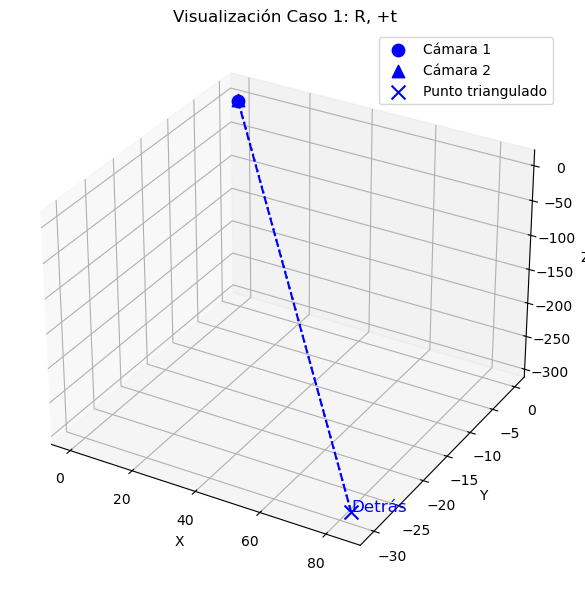

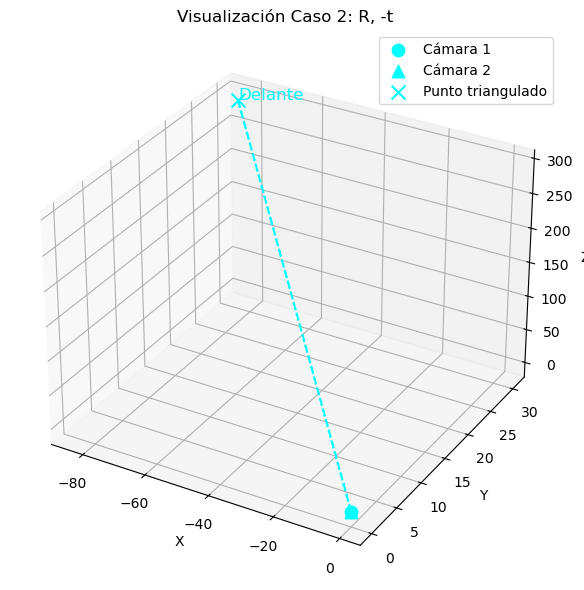

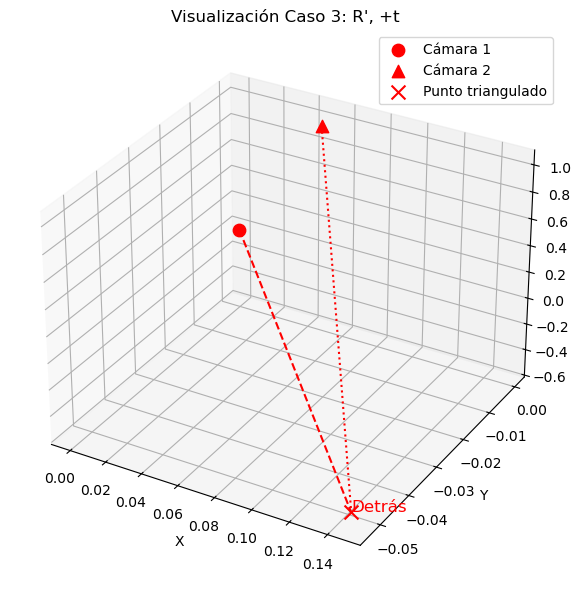

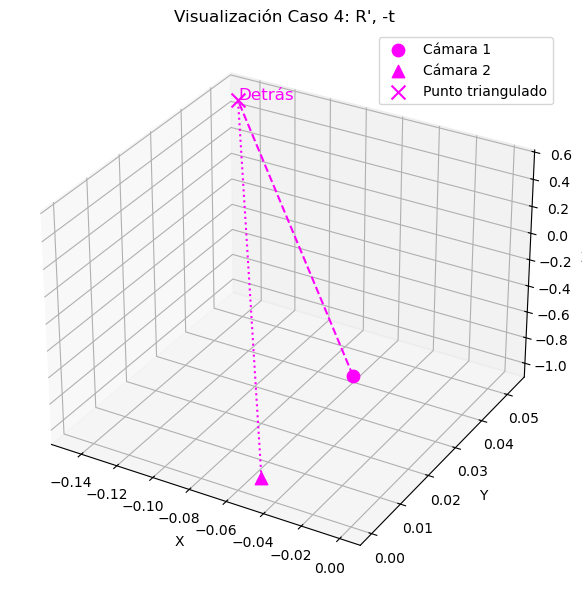

In [92]:
visualize_each_configuration(E, y1, y2)


In [70]:
def calcular_homografias_rectificacion(K, R, t):
    # Centros de cámaras en coordenadas de la cámara 1
    c1 = np.zeros(3)
    c2 = -R.T @ t

    # Eje x de la nueva base: dirección línea base entre cámaras
    x = (c2 - c1)
    x /= np.linalg.norm(x)

    # Eje z arbitrario (hacia adelante)
    z = np.array([0, 0, 1])

    # Eje y ortogonal a x y z
    y = np.cross(z, x)
    y /= np.linalg.norm(y)

    # Corregir z para que sea ortogonal a x e y
    z = np.cross(x, y)

    # Matriz de rotación para la rectificación
    R_rect = np.vstack((x, y, z))

    # Homografías para las cámaras izquierda y derecha
    H_l = K @ R_rect @ np.linalg.inv(K)
    H_r = K @ R_rect @ R @ np.linalg.inv(K)
    print("Homografía para cámara izquierda (H_l):\n", H_l)
    print("\nHomografía para cámara derecha (H_r):\n", H_r)

    return H_l, H_r

In [72]:
H_l, H_r = calcular_homografias_rectificacion(K, R, t)

Homografía para cámara izquierda (H_l):
 [[-2.96185783e-01 -3.42956576e-01  2.11767160e+03]
 [-1.20377900e+00  1.38607835e-01  8.59042164e+02]
 [-4.36472740e-04 -5.05396291e-04  9.17556355e-01]]

Homografía para cámara derecha (H_r):
 [[-1.97764498e-01 -3.71669879e-01  2.09061285e+03]
 [-1.19658363e+00 -1.90701944e-01  1.18862564e+03]
 [-2.82851218e-04 -6.02536576e-04  9.28340213e-01]]


In [74]:
def rectificar_imagen(img, H):
    h, w = img.shape[:2]
    img_rect = cv2.warpPerspective(img, H, (w, h))
    return img_rect

In [88]:


img_izquierda = cv2.imread('izquierda.jpeg', cv2.IMREAD_COLOR)
img_derecha = cv2.imread('derecha.jpeg', cv2.IMREAD_COLOR)
img_izq = rectificar_imagen(img_izquierda, H_l)
img_der = rectificar_imagen(img_derecha, H_r)

# Mostrar imágenes rectificadas
cv2.imshow("Izquierda Rectificada", img_izq)
cv2.imshow("Derecha Rectificada", img_der)
cv2.waitKey(0)
cv2.destroyAllWindows()

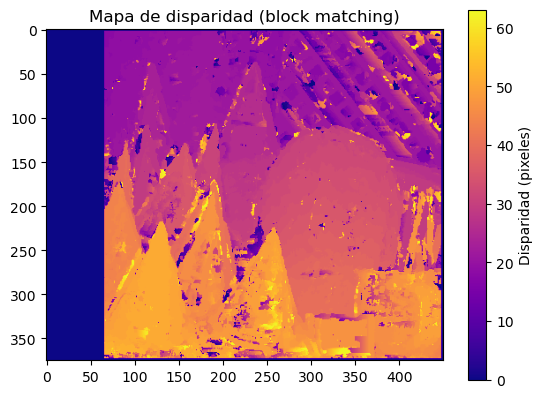

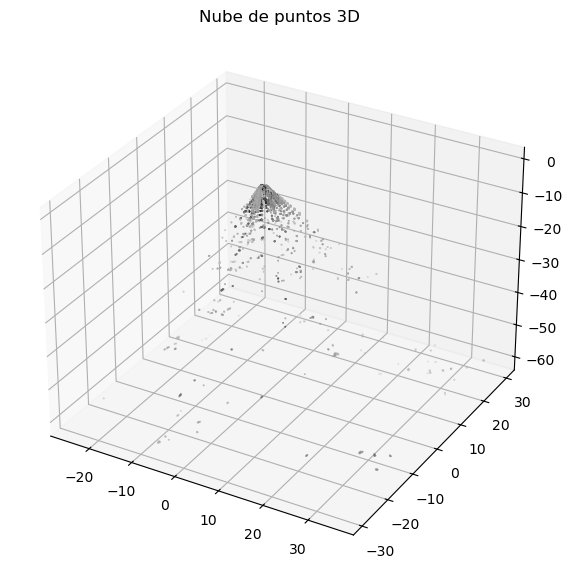

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Il = cv2.imread('im2.png', cv2.IMREAD_GRAYSCALE)
Ir = cv2.imread('im6.png', cv2.IMREAD_GRAYSCALE)

if Il is None or Ir is None:
    raise IOError("No se pudieron cargar las imágenes.")

# Paso 2: Calcular mapa de disparidad por block matching (SAD)
def block_matching(Il, Ir, block_size=5, max_disp=64):
    h, w = Il.shape
    disp_map = np.zeros((h, w), dtype=np.float32)
    offset = block_size // 2

    for y in range(offset, h - offset):
        for x in range(offset + max_disp, w - offset):
            best_offset = 0
            min_sad = float('inf')
            left_block = Il[y-offset:y+offset+1, x-offset:x+offset+1]

            for d in range(max_disp):
                x_shifted = x - d
                if x_shifted - offset < 0:
                    continue
                right_block = Ir[y-offset:y+offset+1, x_shifted-offset:x_shifted+offset+1]
                sad = np.sum(np.abs(left_block.astype(np.int32) - right_block.astype(np.int32)))

                if sad < min_sad:
                    min_sad = sad
                    best_offset = d

            disp_map[y, x] = best_offset
    return disp_map

disparity = block_matching(Il, Ir)

# Paso 3: Mostrar mapa de disparidad
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label='Disparidad (pixeles)')
plt.title('Mapa de disparidad (block matching)')
plt.show()

# Paso 4: Reconstrucción de nube de puntos con una matriz Q simplificada
def generar_nube(disparidad, Il, focal_length=374.0, baseline=0.16):
    h, w = disparidad.shape
    Q = np.array([[1, 0, 0, -w/2],
                  [0, -1, 0, h/2],
                  [0, 0, 0, -focal_length],
                  [0, 0, 1 / baseline, 0]])

    puntos_3D = []
    colores = []

    for y in range(h):
        for x in range(w):
            d = disparity[y, x]
            if d <= 0:
                continue
            punto = np.array([x, y, d, 1.0])
            X = Q @ punto
            X /= X[3]
            puntos_3D.append(X[:3])
            colores.append(Il[y, x] / 255.0)

    return np.array(puntos_3D), np.array(colores)

puntos_3D, colores = generar_nube(disparity, Il)

# Paso 5: Visualizar nube de puntos en matplotlib
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(puntos_3D[:, 0], puntos_3D[:, 1], puntos_3D[:, 2], c=colores, s=0.1, cmap='gray')
ax.set_title('Nube de puntos 3D')
plt.show()

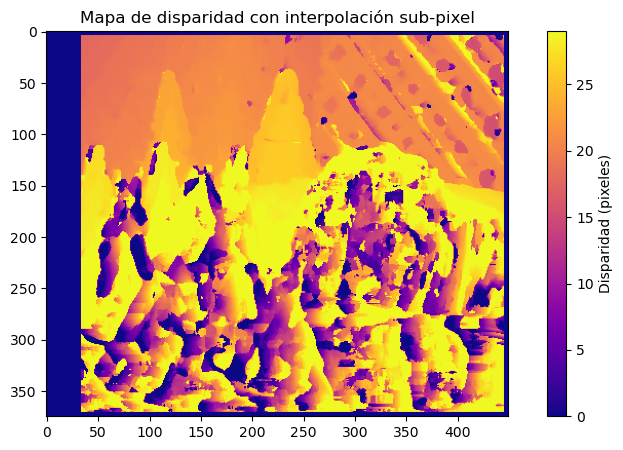

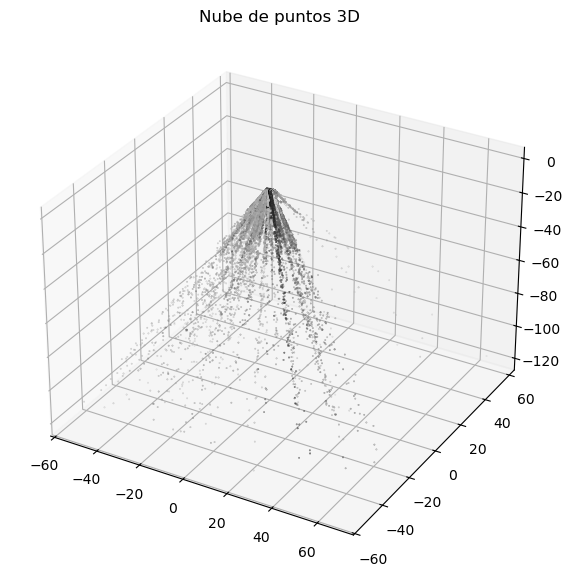

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Cargar imágenes en gris
Il = cv2.imread('im2.png', cv2.IMREAD_GRAYSCALE)
Ir = cv2.imread('im6.png', cv2.IMREAD_GRAYSCALE)
if Il is None or Ir is None:
    raise IOError("No se pudieron cargar las imágenes.")

# Block matching con interpolación sub-pixel
def block_matching_subpixel(Il, Ir, block_size=8, max_disp=30):
    h, w = Il.shape
    disp_map = np.zeros((h, w), dtype=np.float32)
    offset = block_size // 2

    for y in range(offset, h - offset):
        for x in range(offset + max_disp, w - offset):
            min_sad = float('inf')
            best_offset = 0
            sad_list = []

            left_block = Il[y - offset:y + offset + 1, x - offset:x + offset + 1].astype(np.int32)

            for d in range(max_disp):
                x_shifted = x - d
                if x_shifted - offset < 0:
                    sad_list.append(float('inf'))
                    continue
                right_block = Ir[y - offset:y + offset + 1, x_shifted - offset:x_shifted + offset + 1].astype(np.int32)
                sad = np.sum(np.abs(left_block - right_block))
                sad_list.append(sad)
                if sad < min_sad:
                    min_sad = sad
                    best_offset = d

            # Interpolación sub-pixel
            if 1 <= best_offset <= max_disp - 2:
                sad_m1 = sad_list[best_offset - 1]
                sad_0 = sad_list[best_offset]
                sad_p1 = sad_list[best_offset + 1]

                denom = 2 * (sad_m1 + sad_p1 - 2 * sad_0)
                if denom != 0:
                    delta = (sad_m1 - sad_p1) / denom
                    disp_map[y, x] = best_offset + delta
                else:
                    disp_map[y, x] = best_offset
            else:
                disp_map[y, x] = best_offset

    return disp_map

disparity = block_matching_subpixel(Il, Ir)

# Mostrar mapa de disparidad
plt.figure(figsize=(10,5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label='Disparidad (pixeles)')
plt.title('Mapa de disparidad con interpolación sub-pixel')
plt.show()

# Generar nube de puntos 3D
def generar_nube(disparidad, Il, focal_length=374.0, baseline=0.16):
    h, w = disparidad.shape
    Q = np.array([[1, 0, 0, -w/2],
                  [0, -1, 0, h/2],
                  [0, 0, 0, -focal_length],
                  [0, 0, 1 / baseline, 0]])

    puntos_3D = []
    colores = []

    for y in range(h):
        for x in range(w):
            d = disparidad[y, x]
            if d <= 0:
                continue
            punto = np.array([x, y, d, 1.0])
            X = Q @ punto
            X /= X[3]
            puntos_3D.append(X[:3])
            colores.append(Il[y, x] / 255.0)

    return np.array(puntos_3D), np.array(colores)

puntos_3D, colores = generar_nube(disparity, Il)

# Visualizar nube de puntos 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(puntos_3D[:, 0], puntos_3D[:, 1], puntos_3D[:, 2], c=colores, s=0.1, cmap='gray')
ax.set_title('Nube de puntos 3D')
plt.show()